## Potential Vorticity Fluxes 

The PV equation in Z-coordinates also has the form of a passive tracer equation. Here we look at its eddy fluxes. 

$$
\overline{u'q'} = (\overline{u'v'})_x + 0.5*(\overline{v'^2 - u'^2 + \frac{b'^2}{N^2}})_y + (\frac{f_o}{N^2} \overline{u'b'})_z
$$
$$
\overline{v'q'} = -(\overline{u'v'})_y + 0.5*(\overline{v'^2 - u'^2 - \frac{b'^2}{N^2}})_x + (\frac{f_o}{N^2} \overline{v'b'})_z
$$

In [1]:
# load modules 
import xarray as xr
from matplotlib import pyplot as plt
from xgcm import Grid, generate_grid_ds
import numpy as np
%matplotlib inline

In [76]:
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
Model_Tav = xr.open_dataset('./analysis_data_files/ZA_model_Tav.nc')

In [3]:
grid = Grid(Model_Tav)

In [4]:
dx = 5e3
dy = 5e3

g=9.81
alpha=2e-4
f0= -1.1e-4 
beta = 1.4e-11

In [7]:
# no spatial averaging
upvp = grid.interp(grid.interp(Model_Tav.UVtave , 'X'), 'Y', boundary='extend') \
                   - grid.interp(Model_Tav.uVeltave,'X')*grid.interp(
                       Model_Tav.vVeltave, 'Y', boundary='extend')
vpvp = grid.interp(Model_Tav.VVtave, 'Y', boundary='extend')  - grid.interp(
                        Model_Tav.vVeltave, 'Y', boundary='extend')**2
upup = grid.interp(Model_Tav.UUtave, 'X') - grid.interp(Model_Tav.uVeltave, 'X')**2

upbp = g*alpha*(grid.interp(Model_Tav.UTtave,'X') - grid.interp(Model_Tav.uVeltave, 'X'
                                                      )*Model_Tav.Ttave)
vpbp = g*alpha*(grid.interp(Model_Tav.VTtave,'Y', boundary='extend') - grid.interp(
        Model_Tav.vVeltave, 'Y', boundary='extend')*Model_Tav.Ttave)

bpbp = (g*alpha)*(g*alpha)*(Model_Tav.TTtave - Model_Tav.Ttave**2)

N2 = g*alpha*grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend')/
                 grid.diff(Model_Tav.Z, 'Z',boundary='extend'), 
                 'Z', boundary='extend')

In [8]:
# PV fluxes 

## u'q' 
# vorticity terms 
upqp1 =  grid.interp(grid.diff(upvp, 'X')/dx ,'X')

upqp2 = 0.5*grid.interp( grid.diff(vpvp -upup + bpbp/N2, 'Y', boundary='extend')/dy, 
                    'Y', boundary='extend')

# b flux term
upqp3 = f0*grid.interp( grid.diff(upbp/N2 ,'Z', boundary='extend')/
                       grid.diff(Model_Tav.Z, 'Z', boundary='extend'),
                      'Z', boundary='extend')
upqp = upqp1 + upqp2 + upqp3 

# vpqp
# vorticity terms
vpqp1 = 0.5*grid.interp( grid.diff(vpvp -upup - bpbp/N2, 'X')/dx,'X')

vpqp2 = -grid.interp(grid.diff(upvp, 'Y', boundary='extend')/dy ,
                      'Y', boundary='extend')
# b flux term
vpqp3 = f0*grid.interp(grid.diff(vpbp/N2 ,'Z', boundary='extend')/
                       grid.diff(Model_Tav.Z, 'Z', boundary='extend'),
                      'Z', boundary='extend')
vpqp = vpqp1 + vpqp2 + vpqp3 

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1838: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1838: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)


In [9]:
PV_fluxes = xr.Dataset()

PV_fluxes['upqpx'] = upqp1
PV_fluxes['upqpy'] = upqp2
PV_fluxes['upqpz'] = upqp3
PV_fluxes['upqp'] = upqp

PV_fluxes['vpqpx'] = vpqp1
PV_fluxes['vpqpy'] = vpqp2
PV_fluxes['vpqpz'] = vpqp3
PV_fluxes['vpqp'] = vpqp

In [16]:
PV_fluxes_coarse = PV_fluxes.coarsen(XC=10, YC=10).mean()

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### PV gradient 
$$
\nabla \overline{Q} = \beta\hat{j} - f \frac{\partial \mathbf{S}}{\partial z} ,
$$
where $\mathbf{S}= - \nabla B/ B_Z$. 

In [32]:
Sx = - g*alpha*grid.interp(grid.diff(Model_Tav.Ttave, 'X')/dx,'X')/N2
Sy = - g*alpha*grid.interp(grid.diff(Model_Tav.Ttave, 'Y', boundary='extend')/dy,
                           'Y', boundary='extend')/N2

f = f0 + Model_Tav.YC*beta

Q_x = -f*grid.interp(grid.diff(Sx, 'Z', boundary='extend')/
                    grid.diff(Model_Tav.Z, 'Z',boundary='extend'),
                    'Z', boundary='extend')
Q_y = beta -f*grid.interp(grid.diff(Sy, 'Z', boundary='extend')/
                    grid.diff(Model_Tav.Z, 'Z',boundary='extend'),
                    'Z', boundary='extend')


/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1838: RuntimeWarning: invalid value encountered in add
  return 0.5 * (data_left + data_right)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/xgcm/grid.py:1842: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left


In [35]:
PV_grads = xr.Dataset()
PV_grads['dQdx'] = Q_x
PV_grads['dQdy'] = Q_y

In [36]:
PV_grads_coarse = PV_grads.coarsen(XC=10, YC=10).mean()

In [39]:
diff_tensor = xr.open_dataset('analysis_data_files/diff_tensor_ZA_50km.nc')

### Reconstruct fluxes 

Note that unlike when reconstructing fluxes of other tracers, here we only use the top 2X2 part of the diffusivity tensor. This is because there is no vertical gradient in QG PV.

In [58]:
rec_PV_fluxes_coarse= xr.Dataset()
rec_PV_Sfluxes_coarse= xr.Dataset()
rec_PV_Afluxes_coarse= xr.Dataset()

In [59]:
rec_PV_fluxes_coarse['upqp'] = - (diff_tensor.Kcorr.sel(i=0, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.Kcorr.sel(i=0, j=1)*PV_grads_coarse['dQdy'])
rec_PV_fluxes_coarse['vpqp'] = - (diff_tensor.Kcorr.sel(i=1, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.Kcorr.sel(i=1, j=1)*PV_grads_coarse['dQdy'])

rec_PV_Sfluxes_coarse['upqp'] = - (diff_tensor.STcorr.sel(i=0, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.STcorr.sel(i=0, j=1)*PV_grads_coarse['dQdy'])
rec_PV_Sfluxes_coarse['vpqp'] = - (diff_tensor.STcorr.sel(i=1, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.STcorr.sel(i=1, j=1)*PV_grads_coarse['dQdy'])

rec_PV_Afluxes_coarse['upqp'] = - (diff_tensor.ATcorr.sel(i=0, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.ATcorr.sel(i=0, j=1)*PV_grads_coarse['dQdy'])
rec_PV_Afluxes_coarse['vpqp'] = - (diff_tensor.Kcorr.sel(i=1, j=0)*PV_grads_coarse['dQdx'] + 
                            diff_tensor.ATcorr.sel(i=1, j=1)*PV_grads_coarse['dQdy'])

In [82]:
import matplotlib.colors as colors

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


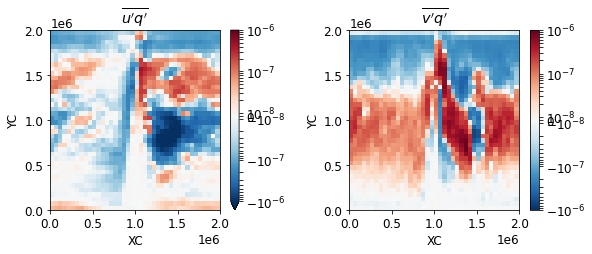

In [100]:
plt.figure(figsize=(8.5,3.7))

plt.subplot(121)
PV_fluxes_coarse['upqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$\overline{u^\prime q^\prime}$')

plt.subplot(122)
PV_fluxes_coarse['vpqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$\overline{v^\prime q^\prime}$')
plt.tight_layout()
plt.savefig('figures/PVflux.pdf')

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


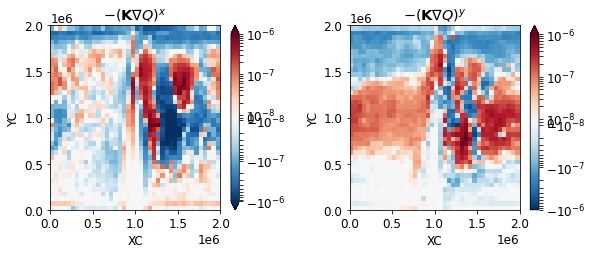

In [101]:
plt.figure(figsize=(8.5,3.7))

plt.subplot(121)
rec_PV_fluxes_coarse['upqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$-(\mathbf{K}\nabla Q)^x$')

plt.subplot(122)
rec_PV_fluxes_coarse['vpqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$-(\mathbf{K}\nabla Q)^y$')
plt.tight_layout()

plt.savefig('figures/KPVflux.pdf')

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


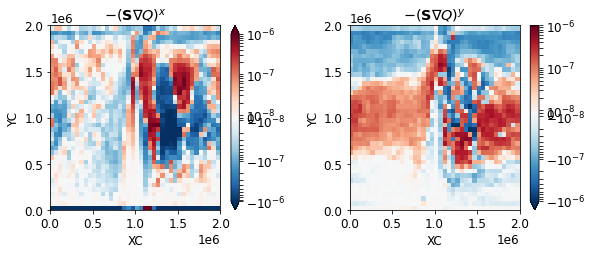

In [102]:
plt.figure(figsize=(8.5,3.7))

plt.subplot(121)
rec_PV_Sfluxes_coarse['upqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$-(\mathbf{S}\nabla Q)^x$')

plt.subplot(122)
rec_PV_Sfluxes_coarse['vpqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$-(\mathbf{S}\nabla Q)^y$')
plt.tight_layout()

plt.savefig('figures/SPVflux.pdf')

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


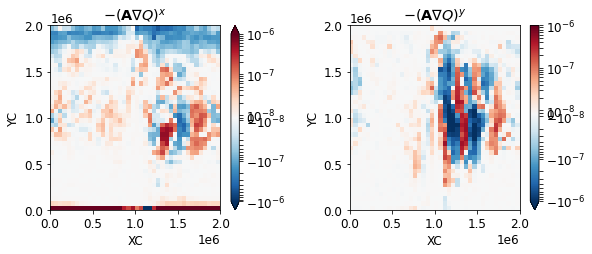

In [103]:
plt.figure(figsize=(8.5,3.7))

plt.subplot(121)
rec_PV_Afluxes_coarse['upqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$-(\mathbf{A}\nabla Q)^x$')

plt.subplot(122)
rec_PV_Afluxes_coarse['vpqp'].sel(Z=-1000, method='nearest').plot(vmin=-1e-6, 
                                                            norm=colors.SymLogNorm(linthresh=1e-8, linscale=0.1),
                                                            rasterized=True,
                                                            cbar_kwargs={'label': ''})

plt.title(r'$-(\mathbf{A}\nabla Q)^y$')
plt.tight_layout()

plt.savefig('figures/APVflux.pdf')

### Correlations analysis

In [60]:
def flux_rec_corrs_ZA_vs_depth(flux, rec_flux): 
    corrU_pearson = ((flux.upqp-flux.upqp.mean(['XC','YC'])) * (rec_flux.upqp-rec_flux.upqp.mean(['XC','YC']))
                    ).mean(['XC','YC']) / (((flux.upqp-flux.upqp.mean(['XC','YC']))**2).mean(['XC','YC']) 
                                * ((rec_flux.upqp-rec_flux.upqp.mean(['XC','YC']))**2).mean(['XC','YC']))**0.5
    
    corrV_pearson = ((flux.vpqp-flux.vpqp.mean(['XC','YC'])) * (rec_flux.vpqp-rec_flux.vpqp.mean(['XC','YC']))
                    ).mean(['XC','YC']) / (((flux.vpqp-flux.vpqp.mean(['XC','YC']))**2).mean(['XC','YC']) 
                                           * ((rec_flux.vpqp-rec_flux.vpqp.mean(['XC','YC']))**2).mean(['XC','YC']))**0.5
    
    
    
    corrs = xr.Dataset({'corrU_pearson':corrU_pearson, 'corrV_pearson':corrV_pearson})
    
    return corrs

In [74]:
corr_K_UpSt = flux_rec_corrs_ZA_vs_depth(PV_fluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_fluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)))

corr_K_DoSt = flux_rec_corrs_ZA_vs_depth(PV_fluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_fluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)))

corr_S_UpSt = flux_rec_corrs_ZA_vs_depth(PV_fluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_Sfluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)))

corr_S_DoSt = flux_rec_corrs_ZA_vs_depth(PV_fluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_Sfluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)))

corr_A_UpSt = flux_rec_corrs_ZA_vs_depth(PV_fluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_Afluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)))

corr_A_DoSt = flux_rec_corrs_ZA_vs_depth(PV_fluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_Afluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)))

corr_AS_UpSt = flux_rec_corrs_ZA_vs_depth(rec_PV_Sfluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_Afluxes_coarse.sel(XC=slice(0,800e3), YC=slice(250e3, 1750e3)))

corr_AS_DoSt = flux_rec_corrs_ZA_vs_depth(rec_PV_Sfluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)), 
                                    rec_PV_Afluxes_coarse.sel(XC=slice(1200e3,2000e3), YC=slice(250e3, 1750e3)))


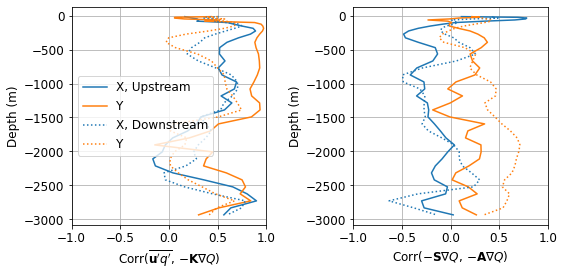

In [98]:
col = plt.get_cmap("tab10")


plt.figure(figsize=(8,4))
plt.subplot(121)
corr_K_UpSt.corrU_pearson.plot(y='Z', color=col(0), label='X, Upstream')
corr_K_UpSt.corrV_pearson.plot(y='Z', color=col(1), label='Y')

corr_K_DoSt.corrU_pearson.plot(y='Z', linestyle=':', color=col(0), label='X, Downstream')
corr_K_DoSt.corrV_pearson.plot(y='Z', linestyle=':', color=col(1), label='Y')
plt.legend()
plt.grid()
plt.xlim([-1, 1])
plt.xlabel(r'Corr($\overline{\mathbf{u}^\prime q^\prime}$, $-\mathbf{K}\nabla Q$)')
plt.ylabel('Depth (m)')

plt.subplot(122)
corr_AS_UpSt.corrU_pearson.plot(y='Z', color=col(0), label='X, Upstream')
corr_AS_UpSt.corrV_pearson.plot(y='Z', color=col(1), label='Y')

corr_AS_DoSt.corrU_pearson.plot(y='Z', linestyle=':', color=col(0), label='X, Downstream')
corr_AS_DoSt.corrV_pearson.plot(y='Z', linestyle=':', color=col(1), label='Y')
#plt.legend()

plt.xlim([-1, 1])
plt.xlabel(r'Corr($-\mathbf{S}\nabla Q$, $-\mathbf{A}\nabla Q$)')
plt.ylabel('Depth (m)')
plt.grid()

plt.tight_layout()
plt.savefig('figures/PV_corr_1.pdf')

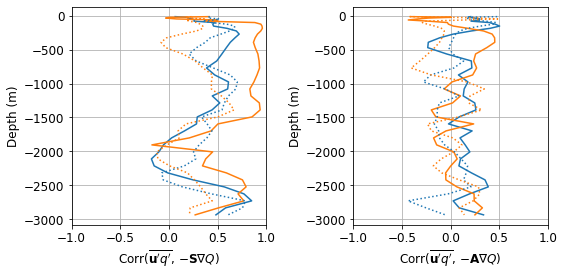

In [99]:
col = plt.get_cmap("tab10")


plt.figure(figsize=(8,4))
plt.subplot(121)
corr_S_UpSt.corrU_pearson.plot(y='Z', color=col(0))
corr_S_UpSt.corrV_pearson.plot(y='Z', color=col(1))


corr_S_DoSt.corrU_pearson.plot(y='Z', linestyle=':', color=col(0))
corr_S_DoSt.corrV_pearson.plot(y='Z', linestyle=':', color=col(1))

plt.grid()
plt.xlim([-1, 1])
plt.xlabel(r'Corr($\overline{\mathbf{u}^\prime q^\prime}$, $-\mathbf{S}\nabla Q$)')
plt.ylabel('Depth (m)')

plt.subplot(122)
corr_A_UpSt.corrU_pearson.plot(y='Z', color=col(0))
corr_A_UpSt.corrV_pearson.plot(y='Z', color=col(1))


corr_A_DoSt.corrU_pearson.plot(y='Z', linestyle=':', color=col(0))
corr_A_DoSt.corrV_pearson.plot(y='Z', linestyle=':', color=col(1))

plt.grid()
plt.xlim([-1, 1])
plt.xlabel(r'Corr($\overline{\mathbf{u}^\prime q^\prime}$, $-\mathbf{A}\nabla Q$)')
plt.ylabel('Depth (m)')

plt.tight_layout()
plt.savefig('figures/PV_corr_2.pdf')